# **Model data processing for Amazon drought study**

In [1]:
import sys; sys.path.append('../'); from wwa import *
import cartopy.crs as ccrs
cproj = ccrs.PlateCarree()

Xn, Xx, Yn, Yx = [-85,-32,-30,15]

# import xesmf as xe
warnings.filterwarnings("ignore", message = ".+F_CONTIGUOUS.+")
# synda_path = "/rds/general/project/wwa/ephemeral/synda_clair/data/"

# fpath = "/rds/general/project/wwa/ephemeral/amazon_drought/"
# tmp_path = fpath + "cordex/tmp/"

sf = gpd.read_file("sf_amazon-basin")

units = {"pr" : "mm/day", "tasmin" : "degC", "tasmax" : "degC"}

DriverError: sf_amazon-basin: No such file or directory

In [ ]:
# methods used in regridding & Taylor diagrams

from taylorDiagram import TaylorDiagram, taylor_scores

def transform_xy(x, y, crs_in = None, crs_out = None):
    
    # transform 1d or 2d coords into 2d coords in another projection
    
    x = np.array(x)
    y = np.array(y)
    
    if x.ndim == 1:
        # tile 1d coordinates into 2d arrays of x, y per cell
        x_2d = np.tile(np.array(x), (len(y), 1))
        y_2d = np.tile(np.array([y]).transpose(), (1, len(x)))
    else:
        # coordinates are already 2d arrays
        x_2d = x
        y_2d = y
    
    if crs_in is None or crs_out is None:
        # return tiled points on original grid
        return x_2d, y_2d
        
    else:
        # transform and return
        xy_transf = crs_out.transform_points(crs_in, x_2d, y_2d)
        return xy_transf[:,:,0], xy_transf[:,:,1]
    

def vertices_from_centres(x_coords, y_coords, crs_in = None, crs_out = None):
    
    # Compute vertices on regular grid of 1d x, y coordinates
    
    if np.array(x_coords).ndim > 1 or np.array(y_coords).ndim > 1:
        print("Coordinates must be one-dimensional")
        return
    
    # compute offsets needed to find midpoints
    x_offset = np.diff(x_coords) / 2
    y_offset = np.diff(y_coords) / 2
    
    # use offsets to obtain vectors of cell midpoints (adds 1 to each dimension)
    x_bounds = xr.concat([x_coords[0] - x_offset[0], x_coords[:-1] + x_offset, x_coords[-1] + x_offset[-1]], dim = x_coords.dims[0])
    y_bounds = xr.concat([y_coords[0] - y_offset[0], y_coords[:-1] + y_offset, y_coords[-1] + y_offset[-1]], dim = y_coords.dims[0])
    
    # expand vectors of bounds to grid of corners (& transform projection if necessary)
    xvert, yvert = transform_xy(x_bounds, y_bounds, crs_in = crs_in, crs_out = crs_out)
    
    return(xvert, yvert)


def add_grid(da, x_coords, y_coords, crs_in = None, crs_out = None):
    
    # return grid with vertices based on regular grid of 1d x, y coordinates, to be used in regridding using xe.Regridder
    if type(x_coords) == str: x_coords = da[x_coords]
    if type(y_coords) == str: y_coords = da[y_coords]
    
    if np.array(x_coords).ndim > 1 or np.array(y_coords).ndim > 1:
        print("Coordinates must be one-dimensional")
        return
    
    lon, lat = transform_xy(x_coords, y_coords, crs_in, crs_out)
    lon_b, lat_b = vertices_from_centres(x_coords, y_coords, crs_in, crs_out)
    
    da = da.assign_coords(lon = ([y_coords.name, x_coords.name], lon, x_coords.attrs), lat = ([y_coords.name, x_coords.name], lat, y_coords.attrs),
                          lon_b = ([y_coords.name+"_b", x_coords.name+"_b"], lon_b), lat_b = ([y_coords.name+"_b", x_coords.name+"_b"], lat_b))
    
    return da

In [ ]:
abridge_gcm = {'CCCma-CanESM2' : "CanESM2",
               "CNRM-CERFACS-CNRM-CM5" : "CNRM-CM5",
               'CSIRO-QCCCE-CSIRO-Mk3-6-0' : 'CSIRO-Mk3-6-0',
               "ICHEC-EC-EARTH" : "EC-EARTH",
               'IPSL-IPSL-CM5A-LR' : 'IPSL-CM5A-LR',
               'IPSL-IPSL-CM5A-MR' : 'IPSL-CM5A-MR',
               'MIROC-MIROC5' : 'MIROC5',
               'MOHC-HadGEM2-ES' : 'HadGEM2-ES',
               'MPI-M-MPI-ESM-LR' : 'MPI-ESM-LR',
               'MPI-M-MPI-ESM-MR' : 'MPI-ESM-MR',
               'NCC-NorESM1-M' : 'NorESM1-M',
               'NOAA-GFDL-GFDL-ESM2G' : 'GFDL-ESM2G',
               'NOAA-GFDL-GFDL-ESM2M' : 'GFDL-ESM2M'}

abridge_rcm = {'CLMcom-CCLM4-8-17': "CCLM4-8-17",
                 'CLMcom-ETH-COSMO-crCLIM-v1-1': "COSMO-crCLIM-v1-1",
                 'CNRM-ALADIN63':"ALADIN63",
                 'DMI-HIRHAM5':"HIRHAM5",
                 'GERICS-REMO2015':"REMO2015",
                 'ICTP-RegCM4-3':"RegCM4-3",
                 'ICTP-RegCM4-6':"RegCM4-6",
                 'ICTP-RegCM4-7':"RegCM4-7",
                 'IPSL-WRF381P':"WRF381P",
                 'KNMI-RACMO22E':"RACMO22E",
                 'MOHC-HadREM3-GA7-05':"HadREM3-GA7-05",
                 'MPI-CSC-REMO2009':"REMO2009",
                 'SMHI-RCA4':"RCA4",
                 'UCAN-WRF341I':"WRF341I",
                 'UHOH-WRF361H':"WRF361H"}

In [ ]:
rcm_colours = {'ALADIN63'          : 'mediumblue',
               'ALARO-0'           : 'violet',
               'CCLM4-8-17'        : 'blueviolet',
               'COSMO-crCLIM-v1-1' : 'mediumvioletred',
               'HIRHAM5'           : 'red',
               'HadREM3-GA7-05'    : 'darkorange',
               'RACMO22E'          : 'gold',
               'RCA4'              : 'yellowgreen',
               'REMO2015'          : 'green',
               'REMO2009'          : 'green',
               'RegCM4-6'          : 'darkturquoise',
               'WRF381P'           : 'dodgerblue'}

---
# **MSWEP/MSWX reference data**

### **Concatenate daily files**

In [ ]:
tmp_path = "../../00_WWA_project_folder/ephemeral/amazon_drought/mswep/tmp/"

# load example data, create regionmask
mswep = xr.open_dataset("../../00_WWA_project_folder/live/data/mswep_past/1980001.nc").squeeze(drop = True).precipitation.sel(lon = slice(Xn,Xx), lat = slice(Yx, Yn))
rm = regionmask.mask_3D_geopandas(sf, mswep.lon, mswep.lat).squeeze(drop = True)

# trim to spatial extent and save each year at monthly resolution
for y in range(1981, 2011):
    
    fl = sorted(glob.glob("../../00_WWA_project_folder/live/data/mswep_*/"+str(y)+"*.nc"))
    ds = xr.open_mfdataset(fl).precipitation.sel(lon = slice(Xn,Xx), lat = slice(Yx, Yn))
    
    # save monthly gridded data (for spatial pattern) and daily time series (for seasonal cycle)
    ds.resample(time = "MS").sum().to_netcdf(tmp_path+"mswep-monthly_"+str(y)+".nc")
    ds.where(rm == 1).mean(["lat", "lon"]).to_netcdf(tmp_path+"mswep-ts_"+str(y)+".nc")

In [ ]:
# trim to spatial extent and save each year at monthly resolution
for varnm in ["tmin", "tmax"]:
    
    for y in range(1980, 2011):
    
        fl = sorted(glob.glob("../../00_WWA_project_folder/live/data/mswx/"+varnm+"_*/"+str(y)+"*.nc"))
        ds = xr.open_mfdataset(fl)[varnm].sel(lon = slice(Xn,Xx), lat = slice(Yx, Yn))

        # save monthly gridded data (for spatial pattern) and daily time series (for seasonal cycle)
        ds.resample(time = "MS").mean().to_netcdf(tmp_path+"mswx-"+varnm+"-monthly_"+str(y)+".nc")
        ds.where(rm == 1).mean(["lat", "lon"]).to_netcdf(tmp_path+"mswep-"+varnm+"-ts_"+str(y)+".nc")

### **Compile into seasonal & spatial for reference**

In [61]:
# spatial pattern
mswep_sp = xr.open_mfdataset("../../00_WWA_project_folder/ephemeral/amazon_drought/mswep/tmp/mswep-monthly_*.nc").precipitation
mswep_sp.groupby("time.month").mean().to_netcdf("../../00_WWA_project_folder/ephemeral/amazon_drought/mswep-spatial.nc")


# seasonal cycle
mswep_ts = xr.open_mfdataset("../../00_WWA_project_folder/ephemeral/amazon_drought/mswep/tmp/mswep-ts_*.nc").precipitation
mswep_ts.groupby("time.dayofyear").mean().to_netcdf("../../00_WWA_project_folder/ephemeral/amazon_drought/mswep-seasonal.nc")

---
# **CORDEX data**

## **Nino3.4 time series**


In [3]:
for fnm in glob.glob("/rds/general/project/wwa/live/data/cmip5-nino34/*.nc"):
    
    mdl = re.sub(".nc", "", "_".join(fnm.split("_")[-2:]))
    print(mdl)
    
    ts = xr.open_dataset(fnm).nino34_det.rolling(time = 6).mean().groupby("time.month")[11]
    ts = ts.assign_coords(time = ts.time.dt.year).rename(time = "year")
        
    csv_fnm = "amazon-drought_"+re.sub(".nc", "", fnm.split("/")[-1])
    csv_fullpath = "ts/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: CMIP5 "+mdl+" nino34_det - Amazon drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# nino34_det [degC] JJASON mean Nino3.4 detrended using tropical SSTs from 20S-20N at "+csv_fnm
    head = "# year nino34_det"
        
    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    ts.to_dataframe().to_csv(csv_fullpath, sep = " ", mode = "a", header = False)
    
clear_output(wait = False)
print("Done.")

/bin/bash: which: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `which'
/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `module'
/bin/bash: scl: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `scl'
/bin/bash: ml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `ml'
/bin/bash: which: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `which'
/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `module'
/bin/bash: scl: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `scl'
/bin/bash: ml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `ml'
/bin/bash: which: line 1: syntax error: 

## **Extract time series over study region & smaller region for spatial extent**

_NB this script doesn't abridge rcm name - need to modify in next step_

In [3]:
# filter out any models that don't have both historical & rcp85
model_list = sorted(glob.glob(synda_path+"*/*/*"))
model_list = [fp for fp in model_list if (len(glob.glob(fp+"/pr/*rcp85*.nc")) > 0) and (len(glob.glob(fp+"/pr/*hist*.nc")) > 0)]

In [4]:
for fp in model_list:
    print("_".join(fp.split("/")[-3:]))
    
    # something wrong with time bounds in this one, can't open the files
    if "_".join(fp.split("/")[-3:]) in ['MOHC-HadGEM2-ES_r1i1p1_RegCM4-3']: continue
    
    for varnm in ["pr", "tasmin", "tasmax"]:
        fl = glob.glob(fp+"/"+varnm+"/*.nc")
        print("  "+varnm+" ("+str(len(fl))+") ", end = "")
        
        for fnm in fl:
            print(".", end = "")
            new_fnm = tmp_path+re.sub("_rcp85", "", re.sub("_historical", "", re.sub(fp.split("/")[-3], abridge_gcm[fp.split("/")[-3]], fnm.split("/")[-1])))
            
            # skip if file has already been processed
            if os.path.exists(re.sub("day","ts",new_fnm)) and os.path.exists(re.sub("day","sp",new_fnm)): continue
            
            # load data, convert to correct units
            da = xr.open_dataset(fnm)[varnm]
            da = convert_units_to(da, units[varnm])
            if "height" in da.coords: da.reset_coords("height", drop = True)  # clean up unwanted extra coordinates
            
            # fix dimension names if necessary
            if "longitude" in da.coords: da = da.rename(longitude = "lon", latitude = "lat")
                
            # identify primary coordinates
            if "rlon" in da.dims:
                xdim, ydim = ["rlat", "rlon"]
            elif "x" in da.dims:
                xdim, ydim = ["x", "y"]
            else:
                print(da.dims)
                continue
            
            # get daily time series over study region
            rm = regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True)
            ts = da.where(rm == 1).mean([xdim, ydim])
            ts.to_netcdf(re.sub("day","ts",new_fnm))
            
            # get monthly series over larger region for spatial pattern
            box = np.logical_and(np.logical_and(da.lon >= Xn, da.lon <= Xx), np.logical_and(da.lat >= Yn, da.lat <= Yx))
            box = box.where(box == 1).dropna(xdim, "all").dropna(ydim, "all")
            sp = da.sel({xdim : box[xdim], ydim : box[ydim]}).sortby("time").resample(time = "MS").mean()
            sp.to_netcdf(re.sub("day","sp",new_fnm))
            
        print("")
clear_output(wait = False)
print("Done.")

Done.


### **Compile monthly time series**

In [15]:
mdl_list = list(set(["_".join(fnm.split("_")[2:6]) for fnm in glob.glob(tmp_path+"*_ts_*.nc")]))
cordex_path = "/rds/general/project/wwa/ephemeral/amazon_drought/cordex/"

for mdl in mdl_list:

    mdl_abridged = re.sub(mdl.split("_")[-1], abridge_rcm[mdl.split("_")[-1]], mdl)
    print(mdl_abridged)

    for varnm in ["pr", "tasmin", "tasmax"]:
        
        fl = sorted(glob.glob(tmp_path+varnm+"_"+mdl+"*_ts_*.nc"))
        if len(fl) == 0: continue
        new_fnm = cordex_path+varnm+"_"+mdl_abridged+"_monthly_"+fl[0][-20:-12]+fl[-1][-12:]
        if os.path.exists(new_fnm): continue
        
        da = xr.concat([xr.open_dataset(fnm) for fnm in fl], "time")[varnm].sortby("time")
        
        if varnm == "pr":
            da = da.resample(time = "MS").sum()
        else:
            da = da.resample(time = "MS").mean()
        
        da = convert_calendar(da, "default", align_on = "date")
        da.to_netcdf(new_fnm)
clear_output(wait = False)
print("Done.")

Done.


### **Spatial pattern**

In [ ]:
sp_path = "/rds/general/project/wwa/ephemeral/amazon_drought/cordex/spatial/"

mdl_list = list(set(["_".join(fnm.split("_")[2:6]) for fnm in glob.glob(tmp_path+"*_ts_*.nc")]))

for mdl in mdl_list:

    mdl_abridged = re.sub(mdl.split("_")[-1], abridge_rcm[mdl.split("_")[-1]], mdl)
    print(mdl_abridged)

    for varnm in ["pr", "tasmin", "tasmax"]:
        
        fl = sorted(glob.glob(tmp_path+varnm+"_"+mdl+"*_sp_*.nc"))
        if len(fl) == 0: continue
        new_fnm = sp_path+varnm+"_"+mdl_abridged+"_spatial_"+fl[0][-20:-12]+fl[-1][-12:]
        if os.path.exists(new_fnm): continue
        
        da = xr.concat([xr.open_dataset(fnm) for fnm in fl], "time")[varnm].sortby("time")
        sp = da.sel(time = slice("1980", "2010")).groupby("time.month").mean()
        
        if "height" in sp.coords: sp = sp.reset_coords(drop = True)
        
        sp.to_netcdf(new_fnm)
clear_output(wait = False)
print("Done.")

### **Seasonal cycle**

In [31]:
mdl_list = list(set(["_".join(fnm.split("_")[2:6]) for fnm in glob.glob(tmp_path+"*_ts_*.nc")]))
sc_path = "/rds/general/project/wwa/ephemeral/amazon_drought/cordex/seasonal/"

for mdl in mdl_list:

    mdl_abridged = re.sub(mdl.split("_")[-1], abridge_rcm[mdl.split("_")[-1]], mdl)
    print(mdl_abridged)

    for varnm in ["pr", "tasmin", "tasmax"]:
        
        fl = sorted(glob.glob(tmp_path+varnm+"_"+mdl+"*_ts_*.nc"))
        if len(fl) == 0: continue
        new_fnm = sc_path+varnm+"_"+mdl_abridged+"_seasonal_"+fl[0][-20:-12]+fl[-1][-12:]
        if os.path.exists(new_fnm): continue
        
        da = xr.concat([xr.open_dataset(fnm) for fnm in fl], "time")[varnm].sortby("time")
        sc = da.sel(time = slice("1980", "2010")).groupby("time.dayofyear").mean()
        
        if "height" in sc.coords: sc = sc.reset_coords(drop = True)
        
        sc.to_netcdf(new_fnm)
clear_output(wait = False)
print("Done.")

Done.


### **Seasonal cycle - precip**

In [28]:
fpath = "/rds/general/project/wwa/ephemeral/amazon_drought/"
mswx = xr.open_dataset(fpath+"mswep-seasonal.nc").precipitation

In [29]:
cordex = xr.concat([xr.open_dataset(fnm).expand_dims(run = ["_".join(fnm.split("_")[3:6])]).pr for fnm in sorted(glob.glob(fpath+"cordex/seasonal/pr_*.nc"))], "run")

In [30]:
# load other obs. datasets for comparison
era5 = xr.open_dataset("cordex_seasonal/era_pr_sc.nc").tp
era5_corr = xr.corr(era5, mswx)
era5_sd = era5.std()

In [31]:
corrs, sds, ref_sd = taylor_scores(cordex, mswx)
max_sd = max(np.ceil(max(sds)) / ref_sd, 1.1)
min_corr = min(corrs)

In [32]:
# create dataframe of scores for easier model evaluation
td_df = pd.DataFrame({"mdl" : [re.sub("i1p1","",r) for r in cordex.run.values], "cor" : corrs, "sd" : sds}).set_index("mdl")

td_df.loc[td_df.cor >= 0.8, "eval"] = "good"
td_df.loc[td_df.cor >= 0.7, "eval"] = "reasonable"
td_df.loc[(td_df.cor < 0.7) | (td_df.sd < 1.6), "eval"] = "bad"

td_df.sort_index().to_csv("taylor-diagram_pr_cordex_seasonal-scores.csv")

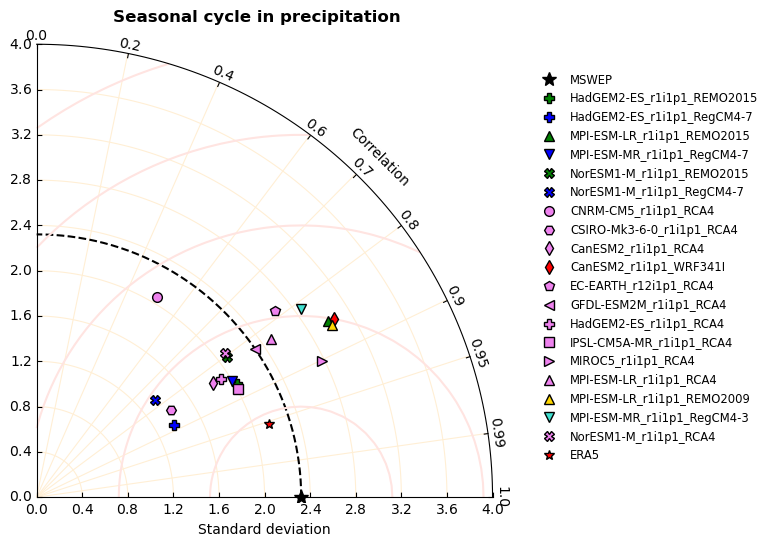

In [37]:
# make Taylor diagram
fig = plt.figure(figsize = (6,6), dpi= 100, facecolor='w', edgecolor='k')
td = TaylorDiagram(ref_sd, fig = fig, label = "MSWEP", srange = (0, max_sd), extend = False)

td.add_contours(colors = "mistyrose") # lines of equal RMSE
td.add_grid(color = "papayawhip")  # lines of equal correlation & SD

for i in range(len(corrs)):
    
    mdl = cordex.run.values[i]
    gcm_marker = gcm_markers["_".join(mdl.split("_")[:2])]
    rcm_colour = rcm_colours[mdl.split("_")[2]]
    
    td.add_sample(sds[i], corrs[i], marker = gcm_marker, ms = 7, ls = '', mfc = rcm_colour, mec = "black", label = mdl)
    
td.add_sample(era5_sd, era5_corr, marker = "*", ms = 7, ls = '', mfc = "red", mec = "black", label = "ERA5")

# fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center left', bbox_to_anchor = (1,0.5), ncols = 2)
plt.suptitle("Seasonal cycle in precipitation", fontweight = "bold", y = 0.93)

fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center left', bbox_to_anchor = (0.95,0.5), ncols = 1, edgecolor = "w")

plt.savefig(fpath+"taylor-diagram_pr_seasonal_cordex.png")

### **Time series for climate explorer**

In [32]:
for fnm in glob.glob("/rds/general/project/wwa/ephemeral/amazon_drought/cordex/*.nc"):
    print(fnm)
    varnm = fnm.split("/")[-1].split("_")[0]
    da = xr.open_dataset(fnm)[varnm].rolling(time = 6)
    
    if varnm == "pr":
        ts = convert_units_to(da.sum(), "mm/day")
    else:
        ts = convert_units_to(da.mean(), "degC")
        
    ts = ts.groupby("time.month")[11]
    if "height" in ts.coords: ts = ts.reset_coords(drop = True)
        
    new_fnm = re.sub("monthly", "JJASON", fnm.split("/")[-1])
    ts.to_netcdf("/rds/general/project/wwa/ephemeral/amazon_drought/cordex/ts_for_spi/"+new_fnm)

/rds/general/project/wwa/ephemeral/amazon_drought/cordex/tasmax_SAM-22_MPI-ESM-MR_r1i1p1_RegCM4-7_monthly_19700101-20501231.nc
/rds/general/project/wwa/ephemeral/amazon_drought/cordex/tasmin_SAM-22_NorESM1-M_r1i1p1_RegCM4-7_monthly_19700101-20501231.nc
/rds/general/project/wwa/ephemeral/amazon_drought/cordex/tasmax_SAM-22_NorESM1-M_r1i1p1_REMO2015_monthly_19700101-20501231.nc
/rds/general/project/wwa/ephemeral/amazon_drought/cordex/tasmax_SAM-44_GFDL-ESM2M_r1i1p1_RCA4_monthly_19510101-20501231.nc
/rds/general/project/wwa/ephemeral/amazon_drought/cordex/tasmin_SAM-44_HadGEM2-ES_r1i1p1_RCA4_monthly_19510101-20501230.nc
/rds/general/project/wwa/ephemeral/amazon_drought/cordex/tasmin_SAM-22_HadGEM2-ES_r1i1p1_RegCM4-7_monthly_19700101-20501230.nc
/rds/general/project/wwa/ephemeral/amazon_drought/cordex/tasmax_SAM-22_NorESM1-M_r1i1p1_RegCM4-7_monthly_19700101-20501231.nc
/rds/general/project/wwa/ephemeral/amazon_drought/cordex/tasmin_SAM-22_MPI-ESM-LR_r1i1p1_REMO2015_monthly_19700101-2050123

In [31]:
for mdl in mdl_list:

    mdl_abridged = re.sub(mdl.split("_")[-1], abridge_rcm[mdl.split("_")[-1]], mdl)
    print(mdl_abridged)

    for varnm in ["pr", "tasmin", "tasmax"]:
        
        fl = sorted(glob.glob(tmp_path+varnm+"_"+mdl+"*_ts_*.nc"))
        if len(fl) == 0: continue
        new_fnm = sc_path+varnm+"_"+mdl_abridged+"_seasonal_"+fl[0][-20:-12]+fl[-1][-12:]
        if os.path.exists(new_fnm): continue
        
        da = xr.concat([xr.open_dataset(fnm) for fnm in fl], "time")[varnm].sortby("time")
        sc = da.sel(time = slice("1980", "2010")).groupby("time.dayofyear").mean()
        
        if "height" in sc.coords: sc = sc.reset_coords(drop = True)
        
        sc.to_netcdf(new_fnm)
clear_output(wait = False)
print("Done.")

Done.


## **Regrid model data to target grid**

Use conservative_normed to avoid edge effects around missing values

### **ERA5**
_Need to update Cartopy to latest version - and probably also to install xesmf_

In [22]:
# load reference dataset
sp_ref = wrap_lon(xr.open_dataset("mswep-spatial.nc"))

# add grid to reference data for easier regridding
lonvert, latvert = vertices_from_centres(sp_ref.lon, sp_ref.lat)
sp_ref["lon_b"] = (["latb", "lonb"], lonvert)
sp_ref["lat_b"] = (["latb", "lonb"], latvert)

# load ERA5 & add grid
era5 = wrap_lon(xr.open_dataset("cordex_spatial/era_pr_spatial.nc"))
lonvert, latvert = vertices_from_centres(era5.lon, era5.lat)
era5["lon_b"] = (["latb", "lonb"], lonvert)
era5["lat_b"] = (["latb", "lonb"], latvert)

# create regridder
era5_rg = xe.Regridder(era5, sp_ref, "conservative_normed", unmapped_to_nan = True)

# regrid & save
era5_regridded = era5_rg(era5.tp).rename("pr")
era5_regridded.to_netcdf("cordex_spatial/era5_pr_regidded.nc")

# regrid tmax & tmin as well
era5_rg(wrap_lon(xr.open_dataset("cordex_spatial/era_tmin_spatial.nc")).tmin).rename("tasmin").to_netcdf("cordex_spatial/era5_tasmin_regidded.nc")
era5_rg(wrap_lon(xr.open_dataset("cordex_spatial/era_tmax_spatial.nc")).tmax).rename("tasmax").to_netcdf("cordex_spatial/era5_tasmax_regidded.nc")

### **CORDEX**
_Need to update Cartopy to latest version - and probably also to install xesmf_

In [26]:
crs = {'RCA4': ccrs.RotatedPole(pole_longitude = -56.06, pole_latitude = 70.6),
        'REMO2009': ccrs.RotatedPole(pole_longitude = -56.06, pole_latitude = 70.6),
        'REMO2015': ccrs.RotatedPole(pole_longitude = -56.06, pole_latitude = 70.6),
        'RegCM4-3': ccrs.ObliqueMercator(central_longitude=-59.0, central_latitude=-22.0, false_easting=-12500.0, false_northing=-12500.0, 
                                               scale_factor=1.0, azimuth=89.999999),
        'RegCM4-7': ccrs.ObliqueMercator(central_longitude=-59.0, central_latitude=-22.0, false_easting=-12500.0, false_northing=-12500.0, 
                                               scale_factor=1.0, azimuth=89.999999),
        'WRF341I': ccrs.RotatedPole(pole_longitude = -56.06, pole_latitude = 70.6)
      }

In [27]:
# load reference dataset
sp_ref = xr.open_dataset("mswep-spatial.nc")

# add grid to reference data for easier regridding
lonvert, latvert = vertices_from_centres(sp_ref.lon, sp_ref.lat)
sp_ref["lon_b"] = (["latb", "lonb"], lonvert)
sp_ref["lat_b"] = (["latb", "lonb"], latvert)

In [ ]:
varnm = "tasmax"
fl = glob.glob("cordex_spatial/"+varnm+"_*.nc")

regridded_cordex = []
for fnm in fl:
    
    print(fnm)
        
    ds = xr.open_dataset(fnm)
    
    dsproj = crs[fnm.split("_")[-3]]
    
    if "height" in ds.coords: ds = ds.reset_coords("height", drop = True)
    
    if "rlon" in ds.dims:
        ds = add_grid(ds, ds.rlon, ds.rlat, crs_in = dsproj, crs_out = cproj)
    else:
        ds = add_grid(ds, ds.x, ds.y, crs_in = dsproj, crs_out = cproj)
        
    regrid = xe.Regridder(ds, sp_ref, method = "conservative_normed", unmapped_to_nan = True)
    regridded = regrid(ds).reset_coords(drop = True).squeeze().expand_dims(run = ["_".join(fnm.split("_")[3:6])])
    
    regridded_cordex.append(regridded)

regridded_cordex = xr.concat(regridded_cordex, "run").rename(varnm)
regridded_cordex.to_netcdf(varnm+"_cordex-regridded-to-mswep.nc")

## **Taylor diagrams**

In [3]:
from taylorDiagram import TaylorDiagram, taylor_scores

# plotting parameters
gcm_markers = {'CNRM-CM5_r1i1p1': 'o',
                 'CSIRO-Mk3-6-0_r1i1p1': 'H',
                 'CanESM2_r1i1p1': 'd',
                 'EC-EARTH_r12i1p1': 'p',
                 'GFDL-ESM2M_r1i1p1': '<',
                 'HadGEM2-ES_r1i1p1': 'P',
                 'IPSL-CM5A-MR_r1i1p1': 's',
                 'MIROC5_r1i1p1': '>',
                 'MPI-ESM-LR_r1i1p1': '^',
                 'MPI-ESM-MR_r1i1p1': 'v',
                 'NorESM1-M_r1i1p1': 'X'}

rcm_colours = {'RCA4'              : 'violet',
               'REMO2009'          : 'gold',
               'REMO2015'          : 'green',
               'RegCM4-3'          : 'turquoise',
               'RegCM4-7'          : 'blue',
               'WRF341I'           : 'red'}

gcm_handles = [matplotlib.lines.Line2D([], [], color = "w", marker = m, markersize = 6, markeredgecolor = "black", linestyle = "None") for gcm_nm, m in gcm_markers.items()]
rcm_handles = [matplotlib.lines.Line2D([], [], color = c, marker = 'o', markersize = 6, markeredgecolor = "black", linestyle = "None") for rcm_nm, c in rcm_colours.items()]

### **Seasonal cycle - precip**

In [80]:
fpath = "/rds/general/project/wwa/ephemeral/amazon_drought/"
mswx = xr.open_dataset(fpath+"mswep-seasonal.nc").precipitation

In [81]:
cordex = xr.concat([xr.open_dataset(fnm).expand_dims(run = ["_".join(fnm.split("_")[3:6])]).pr 
                    for fnm in sorted(glob.glob("cordex_seasonal/pr_*_seasonal_*.nc"))], "run")

In [82]:
# load other obs. datasets for comparison
era5 = xr.open_dataset("cordex_seasonal/era_pr_sc.nc").tp
era5_corr = xr.corr(era5, mswx)
era5_sd = era5.std()

In [83]:
corrs, sds, ref_sd = taylor_scores(cordex, mswx)
max_sd = max(np.ceil(max(sds)) / ref_sd, 1.1)
min_corr = min(corrs)

In [84]:
# create dataframe of scores for easier model evaluation
td_df = pd.DataFrame({"mdl" : [re.sub("i1p1","",r) for r in cordex.run.values], "cor" : corrs, "sd" : sds}).set_index("mdl")

td_df.loc[td_df.cor >= 0.8, "eval"] = "good"
td_df.loc[td_df.cor >= 0.7, "eval"] = "reasonable"
td_df.loc[(td_df.cor < 0.7) | (td_df.sd < 1.6), "eval"] = "bad"

td_df.sort_index().to_csv("taylor-diagram_pr_cordex_seasonal-scores.csv")

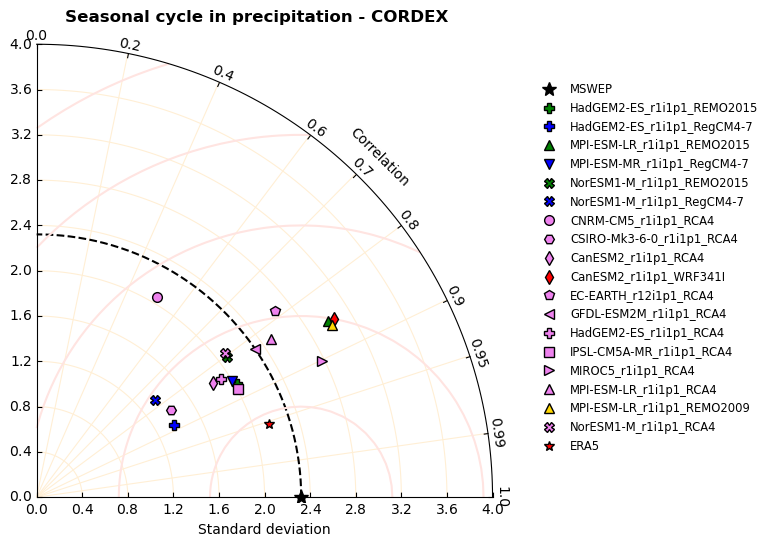

In [22]:
# make Taylor diagram
fig = plt.figure(figsize = (6,6), dpi= 100, facecolor='w', edgecolor='k')
td = TaylorDiagram(ref_sd, fig = fig, label = "MSWEP", srange = (0, max_sd), extend = False)

td.add_contours(colors = "mistyrose") # lines of equal RMSE
td.add_grid(color = "papayawhip")  # lines of equal correlation & SD

for i in range(len(corrs)):
    
    mdl = cordex.run.values[i]
    gcm_marker = gcm_markers["_".join(mdl.split("_")[:2])]
    rcm_colour = rcm_colours[mdl.split("_")[2]]
    
    td.add_sample(sds[i], corrs[i], marker = gcm_marker, ms = 7, ls = '', mfc = rcm_colour, mec = "black", label = mdl)
    
td.add_sample(era5_sd, era5_corr, marker = "*", ms = 7, ls = '', mfc = "red", mec = "black", label = "ERA5")

# fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center left', bbox_to_anchor = (1,0.5), ncols = 2)
plt.suptitle("Seasonal cycle in precipitation - CORDEX", fontweight = "bold", y = 0.93)

fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center left', bbox_to_anchor = (0.95,0.5), ncols = 1, edgecolor = "w")

plt.savefig("fig/taylor-diagram_pr_seasonal_cordex.png")

### **Seasonal cycle - tmin/tmax**

In [45]:
varnm = "tasmax"

mswx_varnm = re.sub("as","",varnm)
mswx = xr.open_dataset("cordex_seasonal/mswx_"+mswx_varnm+"_sc.nc").air_temperature.rename(varnm)

In [46]:
cordex = xr.concat([xr.open_dataset(fnm).expand_dims(run = ["_".join(fnm.split("_")[3:6])])[varnm]
                    for fnm in sorted(glob.glob("cordex_seasonal/"+varnm+"_SAM-*_seasonal_*.nc"))], "run")

In [47]:
# load other obs. datasets for comparison
era5 = xr.open_dataset("cordex_seasonal/era_"+mswx_varnm+"_sc.nc")[mswx_varnm]
era5_corr = xr.corr(era5, mswx)
era5_sd = era5.std()

In [48]:
corrs, sds, ref_sd = taylor_scores(cordex, mswx)
max_sd = max(np.ceil(max(sds)) / ref_sd, 1.1)
min_corr = min(corrs)

In [86]:
# create dataframe of scores for easier model evaluation
td_df = pd.DataFrame({"mdl" : [re.sub("i1p1","",r) for r in cordex.run.values], "cor" : corrs, "sd" : sds}).set_index("mdl")

if varnm == "tasmin":
    td_df.loc[td_df.cor <= 0.9, "eval"] = "reasonable"
    td_df.loc[(td_df.cor > 0.9) & (td_df.sd <= 2*ref_sd), "eval"] = "good"
    td_df.loc[td_df.sd >1.6, "eval"] = "bad"
elif varnm == "tasmax":
    td_df["eval"] = "bad"
    td_df.loc[(td_df.cor > 0.8) & (td_df.sd <= 3*ref_sd), "eval"] = "reasonable"
    td_df.loc[(td_df.cor > 0.9), "eval"] = "reasonable"
    td_df.loc[(td_df.cor > 0.9) &(td_df.sd <= 2*ref_sd), "eval"] = "good"

td_df.sort_index().to_csv("taylor-diagram_"+varnm+"_cordex_seasonal-scores.csv")

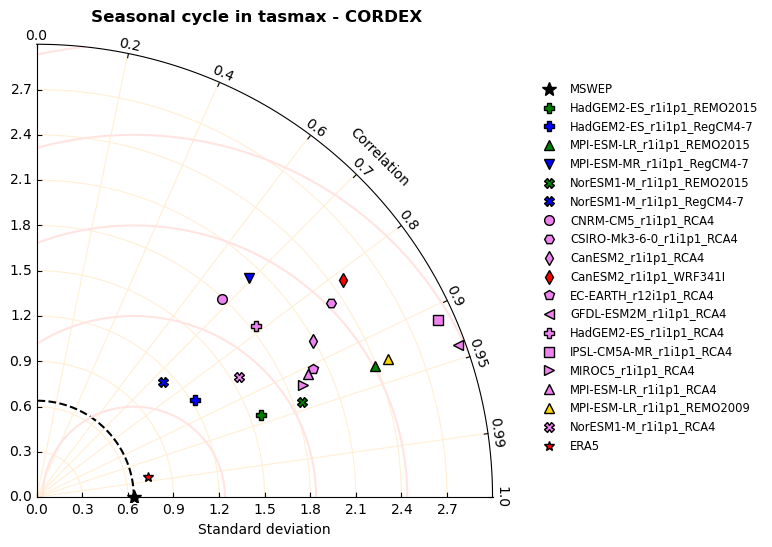

In [79]:
# make Taylor diagram
fig = plt.figure(figsize = (6,6), dpi= 100, facecolor='w', edgecolor='k')
td = TaylorDiagram(ref_sd, fig = fig, label = "MSWEP", srange = (0, max_sd), extend = False)

td.add_contours(colors = "mistyrose") # lines of equal RMSE
td.add_grid(color = "papayawhip")  # lines of equal correlation & SD

for i in range(len(corrs)):
    
    mdl = cordex.run.values[i]
    gcm_marker = gcm_markers["_".join(mdl.split("_")[:2])]
    rcm_colour = rcm_colours[mdl.split("_")[2]]
    
    td.add_sample(sds[i], corrs[i], marker = gcm_marker, ms = 7, ls = '', mfc = rcm_colour, mec = "black", label = mdl)

#     mcol = {"bad" : "red", "reasonable": "gold", "good" : "green"}[td_df.loc[re.sub("i1p1","",mdl),"eval"]]
#     td.add_sample(sds[i], corrs[i], marker = gcm_marker, ms = 7, ls = '', mfc = mcol, mec = "black", label = mdl)
    
td.add_sample(era5_sd, era5_corr, marker = "*", ms = 7, ls = '', mfc = "red", mec = "black", label = "ERA5")

# fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center left', bbox_to_anchor = (1,0.5), ncols = 2)
plt.suptitle("Seasonal cycle in "+varnm+" - CORDEX", fontweight = "bold", y = 0.93)

fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center left', bbox_to_anchor = (0.95,0.5), ncols = 1, edgecolor = "w")

plt.savefig("fig/taylor-diagram_"+varnm+"_seasonal_cordex.png")

### **Spatial pattern - precip**

In [4]:
# fpath = "/rds/general/project/wwa/ephemeral/amazon_drought/"
fpath = "fig/"
mswx = xr.open_dataset("mswep-spatial.nc").precipitation.mean("month") / 30

cordex = xr.open_dataset("pr_cordex-regridded-to-mswep.nc").pr.mean("month")

# get scores for Taylor diagram
corrs, sds, ref_sd = taylor_scores(cordex, mswx)
max_sd = max(np.ceil(max(sds)) / ref_sd, 1.1)

In [5]:
# load other obs. datasets for comparison
era5 = xr.open_dataset("cordex_spatial/era5_pr_regidded.nc").pr
era5_corr = xr.corr(era5, mswx)
era5_sd = era5.std()

In [6]:
# create dataframe of scores for easier model evaluation
td_df = pd.DataFrame({"mdl" : [re.sub("i1p1","",r) for r in cordex.run.values], "cor" : corrs, "sd" : sds}).set_index("mdl")

td_df.loc[td_df.sd < 4, "eval"] = "reasonable"
td_df.loc[td_df.sd > 4, "eval"] = "bad"

td_df.sort_index().to_csv("res/taylor-diagram_pr_cordex_spatial-scores.csv")

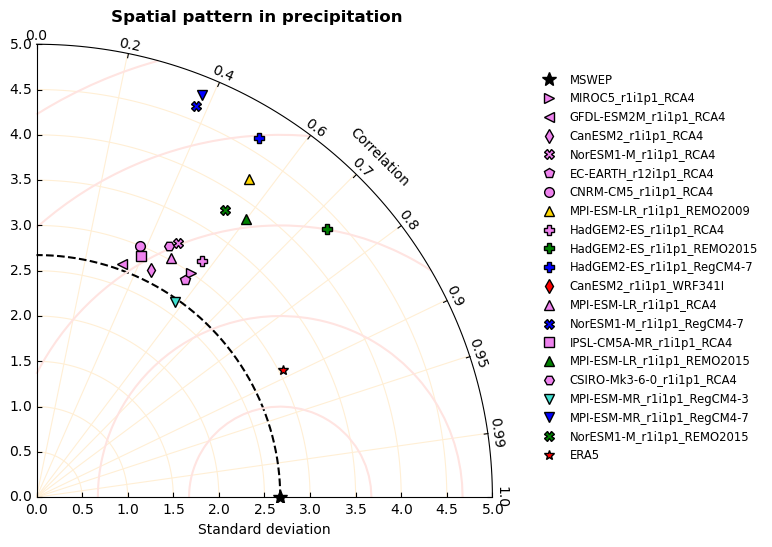

In [7]:
# make Taylor diagram
fig = plt.figure(figsize = (6,6), dpi= 100, facecolor='w', edgecolor='k')
td = TaylorDiagram(ref_sd, fig = fig, label = "MSWEP", srange = (0, max_sd), extend = False)

td.add_contours(colors = "mistyrose") # lines of equal RMSE
td.add_grid(color = "papayawhip")  # lines of equal correlation & SD

for i in range(len(corrs)):
    
    mdl = cordex.run.values[i]
    gcm_marker = gcm_markers["_".join(mdl.split("_")[:2])]
    rcm_colour = rcm_colours[mdl.split("_")[2]]
    
    td.add_sample(sds[i], corrs[i], marker = gcm_marker, ms = 7, ls = '', mfc = rcm_colour, mec = "black", label = mdl)

td.add_sample(era5_sd, era5_corr, marker = "*", ms = 7, ls = '', mfc = "red", mec = "black", label = "ERA5")

# fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center left', bbox_to_anchor = (1,0.5), ncols = 2)
plt.suptitle("Spatial pattern in precipitation", fontweight = "bold", y = 0.93)

fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center left', bbox_to_anchor = (0.95,0.5), ncols = 1, edgecolor = "w")

plt.savefig("fig/taylor-diagram_pr_spatial_cordex.png")

### **Spatial pattern - tmin/tmax**

In [18]:
varnm = "tasmin"

# load reference dataset
mswx_varnm = re.sub("as","",varnm)
mswx = xr.open_dataset("cordex_spatial/mswx_"+mswx_varnm+"_spatial.nc").air_temperature.rename(varnm)

# load other obs. datasets for comparison
# era5 = xr.open_dataset("cordex_spatial/era5_"+varnm+"_regidded")[varnm]
# era5_corr = xr.corr(era5, mswx)
# era5_sd = era5.std()

# load models for comparison
cordex = xr.open_dataset(varnm+"_cordex-regridded-to-mswep.nc")[varnm].mean("month")
corrs, sds, ref_sd = taylor_scores(cordex, mswx)
max_sd = max(np.ceil(max(sds)) / ref_sd, 1.1)
min_corr = min(corrs)

In [19]:
# create dataframe of scores for easier model evaluation
td_df = pd.DataFrame({"mdl" : [re.sub("i1p1","",r) for r in cordex.run.values], "cor" : corrs, "sd" : sds}).set_index("mdl")

if varnm == "tasmin":
    td_df.loc[td_df.cor < 0.6, "eval"] = "bad"
    td_df.loc[td_df.cor <= 0.9, "eval"] = "reasonable"
    td_df.loc[(td_df.cor > 0.9), "eval"] = "good"
elif varnm == "tasmax":
    td_df.loc[td_df.cor < 0.6, "eval"] = "bad"
    td_df.loc[td_df.cor <= 0.9, "eval"] = "reasonable"
    td_df.loc[(td_df.cor > 0.9), "eval"] = "good"

td_df.sort_index().to_csv("res/taylor-diagram_"+varnm+"_cordex_spatial-scores.csv")

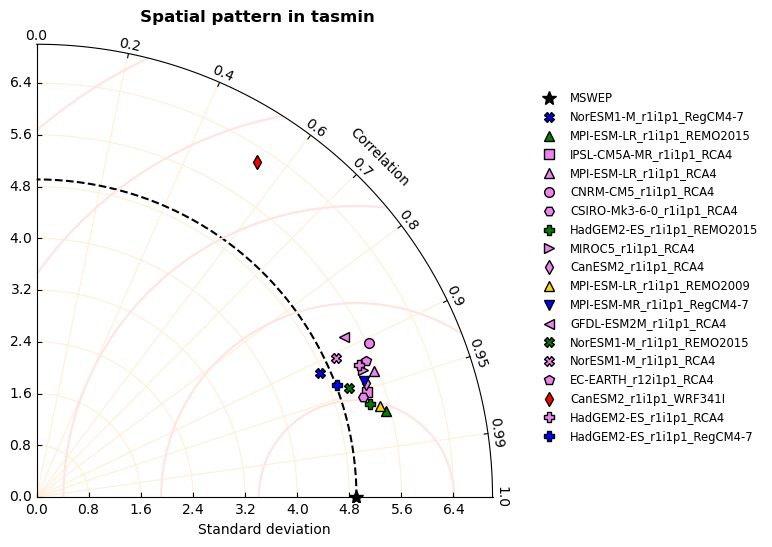

In [20]:
# make Taylor diagram
fig = plt.figure(figsize = (6,6), dpi= 100, facecolor='w', edgecolor='k')
td = TaylorDiagram(ref_sd, fig = fig, label = "MSWEP", srange = (0, max_sd), extend = False)

td.add_contours(colors = "mistyrose") # lines of equal RMSE
td.add_grid(color = "papayawhip")  # lines of equal correlation & SD

for i in range(len(corrs)):
    
    mdl = cordex.run.values[i]
    gcm_marker = gcm_markers["_".join(mdl.split("_")[:2])]
    rcm_colour = rcm_colours[mdl.split("_")[2]]
    
    td.add_sample(sds[i], corrs[i], marker = gcm_marker, ms = 7, ls = '', mfc = rcm_colour, mec = "black", label = mdl)
    
# td.add_sample(era5_sd, era5_corr, marker = "*", ms = 7, ls = '', mfc = "red", mec = "black", label = "ERA5")

# fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center left', bbox_to_anchor = (1,0.5), ncols = 2)
plt.suptitle("Spatial pattern in "+varnm, fontweight = "bold", y = 0.93)

fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center left', bbox_to_anchor = (0.95,0.5), ncols = 1, edgecolor = "w")

plt.savefig("fig/taylor-diagram_"+varnm+"_spatial_cordex.png")

# **HighResMIP**

In [5]:
synda_path = "/rds/general/project/wwa/ephemeral/synda_clair/data/HighResMIP/"
out_path = "/rds/general/project/wwa/ephemeral/amazon_drought/highresmip/tmp/"
ml = glob.glob(synda_path+"*/r1i1*")

In [9]:
# extract spatial data & time series
for fp in ml:
    print("_".join(fp.split("/")[-2:]) + " ("+str(ml.index(fp)+1)+"/"+str(len(ml))+")")
    
    for varnm in ["pr", "tasmin", "tasmax"]:
        
        fl = sorted(glob.glob(fp+"/"+varnm+"_*.nc"))
        print("  "+varnm+" ("+str(len(fl))+") ", end = "")
        
        if len(fl) == 0: 
            print("No data")
            continue
            
        # filter to remove any runs that don't cover the required period
        if min([fnm[-20:-16] for fnm in fl]) > "1980" or max([fnm[-11:-7] for fnm in fl]) < "2023": 
            print(str(min([fnm[-20:-16] for fnm in fl]))+"-"+str(max([fnm[-11:-7] for fnm in fl]))+" only")
            continue
#         fl = [fnm for fnm in fl if fnm[-20:-16] <= "2023"]
            
        for fnm in fl:
            
            print(".", end = "")
            new_fnm = out_path+fnm.split("/")[-1]
            if os.path.exists(re.sub("day","ts",new_fnm)) and os.path.exists(re.sub("day","sp",new_fnm)): continue
                
            da = wrap_lon(convert_units_to(xr.open_dataset(fnm)[varnm].reset_coords(drop = True), units[varnm]))
            
            # fix dimension names if necessary
            if "longitude" in da.coords: da = da.rename(longitude = "lon", latitude = "lat")
            
            # get daily time series over study region
            rm = regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True)
            ts = da.where(rm == 1).mean(["lon", "lat"])
            ts.to_netcdf(re.sub("day","ts",new_fnm))
            
            # get monthly series over larger region for spatial pattern
            box = np.logical_and(np.logical_and(da.lon >= Xn, da.lon <= Xx), np.logical_and(da.lat >= Yn, da.lat <= Yx))
            box = box.where(box == 1).dropna("lon", "all").dropna("lat", "all")
            sp = da.sel({"lon" : box.lon, "lat" : box.lat}).sortby("time").resample(time = "MS").mean()
            sp.to_netcdf(re.sub("day","sp",new_fnm))
            
        print("")
clear_output(wait = False)
print("Done.")

### **Spatial pattern**

In [8]:
tmp_path = "/rds/general/project/wwa/ephemeral/amazon_drought/highresmip/tmp/"
sp_path = "/rds/general/project/wwa/ephemeral/amazon_drought/highresmip/spatial/"

mdl_list = list(set([fnm.split("_")[3] for fnm in glob.glob(tmp_path+"*_ts_*.nc")]))

for mdl in mdl_list:
    
    print(mdl)
    for varnm in ["pr", "tasmin", "tasmax"]:
        
        fl = sorted(glob.glob(tmp_path+varnm+"_sp_"+mdl+"*_r1i1p1f1_*.nc"))
        if len(fl) == 0: continue
            
        years = sorted([fnm.split("_")[-1] for fnm in fl])
        new_fnm = sp_path+varnm+"_"+mdl+"_spatial_"+years[0][:8]+years[-1][8:]
        if os.path.exists(new_fnm): continue
        
        da = xr.concat([xr.open_dataset(fnm) for fnm in fl], "time")[varnm].sortby("time")
        sp = da.sel(time = slice("1980", "2010")).groupby("time.month").mean()
        
        if "height" in sp.coords: sp = sp.reset_coords(drop = True)
        
        sp.to_netcdf(new_fnm)

EC-Earth3P-HR
MPI-ESM1-2-HR
CMCC-CM2-VHR4
GFDL-CM4C192
MPI-ESM1-2-XR
HadGEM3-GC31-LM
NICAM16-9S


ValueError: month must not be empty

### **Seasonal cycle**

In [ ]:
tmp_path = "/rds/general/project/wwa/ephemeral/amazon_drought/highresmip/tmp/"
sc_path = "/rds/general/project/wwa/ephemeral/amazon_drought/highresmip/seasonal/"
mdl_list = list(set([fnm.split("_")[3] for fnm in glob.glob(tmp_path+"*_ts_*.nc")]))

for mdl in mdl_list:

    print(mdl)
    for varnm in ["pr", "tasmin", "tasmax"]:
        
        fl = sorted(glob.glob(tmp_path+varnm+"_"+mdl+"*_ts_*.nc"))
        if len(fl) == 0: continue
        years = sorted([fnm.split("_")[-1] for fnm in fl])
        new_fnm = sp_path+varnm+"_"+mdl+"_seasonal_"+years[0][:8]+years[-1][8:]
        if os.path.exists(new_fnm): continue
        
        da = xr.concat([xr.open_dataset(fnm) for fnm in fl], "time")[varnm].sortby("time")
        sc = da.sel(time = slice("1980", "2010")).groupby("time.dayofyear").mean()
        
        if "height" in sc.coords: sc = sc.reset_coords(drop = True)
        
        sc.to_netcdf(new_fnm)
clear_output(wait = False)
print("Done.")

---
---
# **CMIP6**

## **Regrid model data to target grid**

Use conservative_normed to avoid edge effects around missing values

In [9]:
import xesmf as xe

In [24]:
# load reference dataset
sp_ref = xr.open_dataset("/rds/general/project/wwa/ephemeral/amazon_drought/mswep-spatial.nc")

# add grid to reference data for easier regridding
lonvert, latvert = vertices_from_centres(sp_ref.lon, sp_ref.lat)
sp_ref["lon_b"] = (["latb", "lonb"], lonvert)
sp_ref["lat_b"] = (["latb", "lonb"], latvert)

In [ ]:
varnm = "tasmax"
fl = glob.glob("/rds/general/project/wwa/ephemeral/amazon_drought/cmip/spatial/sp_"+varnm+"_*.nc")

regridded_cmip6 = []
for fnm in fl:
    
    mdl = fnm.split("_")[-4]
    print(mdl)
        
    ds = xr.open_dataset(fnm)  
    if "height" in ds.coords: ds = ds.reset_coords("height", drop = True)
    
    # add grid to data
    lonvert, latvert = vertices_from_centres(ds.lon, ds.lat)
    ds["lon_b"] = (["latb", "lonb"], lonvert)
    ds["lat_b"] = (["latb", "lonb"], latvert)

    regrid = xe.Regridder(ds[varnm], sp_ref, method = "conservative_normed", unmapped_to_nan = True)
    regridded = regrid(ds).reset_coords(drop = True).squeeze().expand_dims(run = [mdl])
    
    regridded_cmip6.append(regridded)

regridded_cmip6 = xr.concat(regridded_cmip6, "run")
regridded_cmip6.to_netcdf(varnm+"_cmip6-regridded-to-mswep.nc")

clear_output(wait = False)
print("Done.")

## **Seasonal cycle - precip**

In [9]:
# target data
mswx = xr.open_dataset("/rds/general/project/wwa/ephemeral/amazon_drought/mswep-seasonal.nc").precipitation

# other obs. datasets for comparison
era5 = xr.open_dataset("cordex_seasonal/era_pr_sc.nc").tp
era5_corr = xr.corr(era5, mswx)
era5_sd = era5.std()

In [10]:
fpath = "/rds/general/project/wwa/ephemeral/amazon_drought/cmip/seasonal/"
cmip6 = xr.concat([xr.open_dataset(fnm).expand_dims(run = [fnm.split("_")[3]]).pr for fnm in sorted(glob.glob(fpath+"pr_sc_*.nc"))], "run")

corrs, sds, ref_sd = taylor_scores(cmip6, mswx)
max_sd = max(np.ceil(max(sds)) / ref_sd, 1.1)
min_corr = min(corrs)

In [11]:
# create dataframe of scores for easier model evaluation
td_df = pd.DataFrame({"mdl" : [re.sub("i1p1","",r) for r in cmip6.run.values], "cor" : corrs, "sd" : sds}).set_index("mdl")

td_df.loc[td_df.cor >= 0.8, "eval"] = "good"
td_df.loc[td_df.cor >= 0.7, "eval"] = "reasonable"
td_df.loc[(td_df.cor < 0.7) | (td_df.sd < 1.6), "eval"] = "bad"

td_df.sort_index().to_csv("taylor-diagram_pr_cmip6_seasonal-scores.csv")

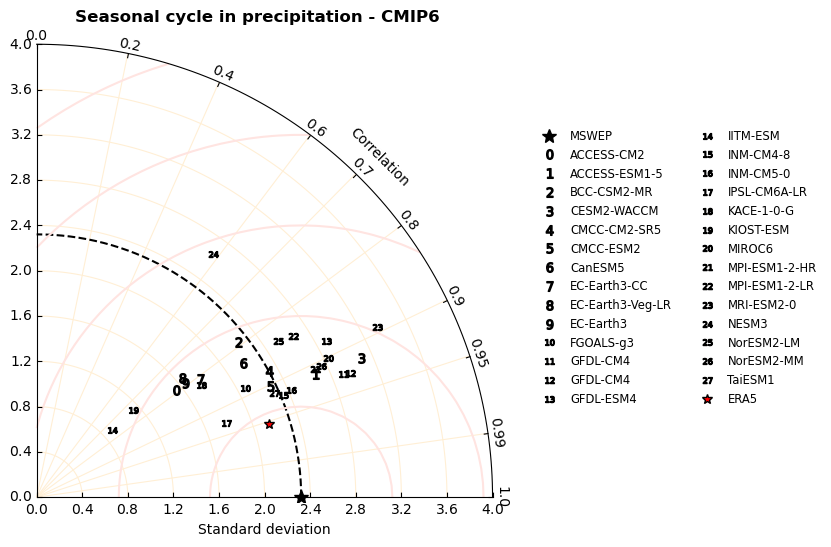

In [12]:
# make Taylor diagram
fig = plt.figure(figsize = (6,6), dpi= 100, facecolor='w', edgecolor='k')
td = TaylorDiagram(ref_sd, fig = fig, label = "MSWEP", srange = (0, max_sd), extend = False)

td.add_contours(colors = "mistyrose") # lines of equal RMSE
td.add_grid(color = "papayawhip")  # lines of equal correlation & SD

for i in range(len(corrs)):
    td.add_sample(sds[i], corrs[i], marker = "$"+str(i)+"$", ms = 7, ls = '', mec = "black", label = cmip6.run.values[i])
    
td.add_sample(era5_sd, era5_corr, marker = "*", ms = 7, ls = '', mfc = "red", mec = "black", label = "ERA5")

# fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center left', bbox_to_anchor = (1,0.5), ncols = 2)
plt.suptitle("Seasonal cycle in precipitation - CMIP6", fontweight = "bold", y = 0.93)

fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center left', bbox_to_anchor = (0.95,0.5), ncols = 1, edgecolor = "w", ncol = 2)

plt.savefig("fig/taylor-diagram_pr_seasonal_cmip6.png")

## **Seasonal cycle - tmin/tmax**

In [86]:
varnm = "tasmin"

mswx_varnm = re.sub("as","",varnm)
mswx = xr.open_dataset("cordex_seasonal/mswx_"+mswx_varnm+"_sc.nc").air_temperature.rename(varnm)

In [87]:
# load other obs. datasets for comparison
era5 = xr.open_dataset("cordex_seasonal/era_"+mswx_varnm+"_sc.nc")[mswx_varnm]
era5_corr = xr.corr(era5, mswx)
era5_sd = era5.std()

In [91]:
fpath = "/rds/general/project/wwa/ephemeral/amazon_drought/cmip/seasonal/"
cmip6 = xr.concat([xr.open_dataset(fnm).expand_dims(run = [fnm.split("_")[3]])[varnm].reset_coords(drop = True) for fnm in sorted(glob.glob(fpath+varnm+"_sc_*.nc"))], "run")

corrs, sds, ref_sd = taylor_scores(cmip6, mswx)
max_sd = max(np.ceil(max(sds)) / ref_sd, 1.1)
min_corr = min(corrs)

In [92]:
# create dataframe of scores for easier model evaluation
td_df = pd.DataFrame({"mdl" : [re.sub("i1p1","",r) for r in cmip6.run.values], "cor" : corrs, "sd" : sds}).set_index("mdl")

if varnm == "tasmin":
    td_df.loc[td_df.cor <= 0.9, "eval"] = "reasonable"
    td_df.loc[(td_df.cor > 0.9) & (td_df.sd <= 1.6), "eval"] = "good"
    td_df.loc[td_df.sd >1.6, "eval"] = "bad"
# else if varnm == "tasmax":

td_df.sort_index().to_csv("taylor-diagram_"+varnm+"_cmip6_seasonal-scores.csv")

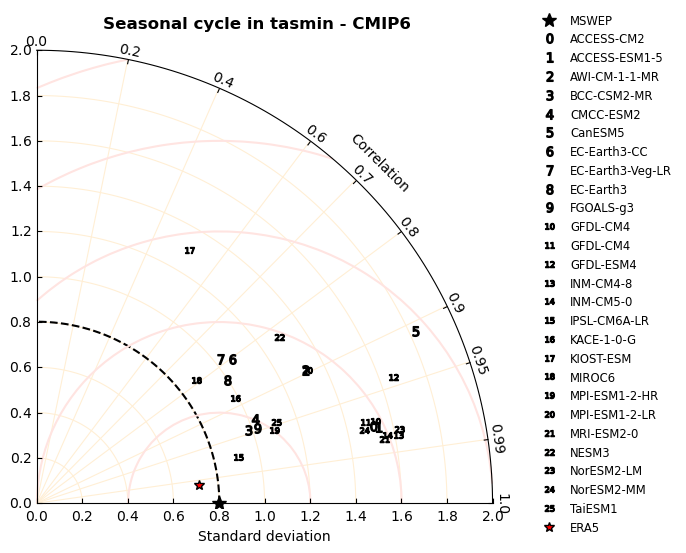

In [93]:
# make Taylor diagram
fig = plt.figure(figsize = (6,6), dpi= 100, facecolor='w', edgecolor='k')
td = TaylorDiagram(ref_sd, fig = fig, label = "MSWEP", srange = (0, max_sd), extend = False)

td.add_contours(colors = "mistyrose") # lines of equal RMSE
td.add_grid(color = "papayawhip")  # lines of equal correlation & SD

for i in range(len(corrs)):
    td.add_sample(sds[i], corrs[i], marker = "$"+str(i)+"$", ms = 7, ls = '', mec = "black", label = cmip6.run.values[i])
    
td.add_sample(era5_sd, era5_corr, marker = "*", ms = 7, ls = '', mfc = "red", mec = "black", label = "ERA5")

# fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center left', bbox_to_anchor = (1,0.5), ncols = 2)
plt.suptitle("Seasonal cycle in "+varnm+" - CMIP6", fontweight = "bold", y = 0.93)

fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center left', bbox_to_anchor = (0.95,0.5), ncols = 1, edgecolor = "w")

plt.savefig("fig/taylor-diagram_"+varnm+"_seasonal_cmip6.png")

## **Spatial pattern - precip**

In [16]:
# target data
mswx = xr.open_dataset("/rds/general/project/wwa/ephemeral/amazon_drought/mswep-spatial.nc").precipitation.mean("month") / 30

# other obs. datasets for comparison
era5 = xr.open_dataset("cordex_spatial/era5_pr_regidded.nc").pr
era5_corr = xr.corr(era5, mswx)
era5_sd = era5.std()

In [17]:
fpath = "/rds/general/project/wwa/ephemeral/amazon_drought/cmip/spatial/"
cmip6 = xr.open_dataset("pr_cmip6-regridded-to-mswep.nc").pr

corrs, sds, ref_sd = taylor_scores(cmip6, mswx)
max_sd = max(np.ceil(max(sds)) / ref_sd, 1.1)
min_corr = min(corrs)

In [18]:
# create dataframe of scores for easier model evaluation
td_df = pd.DataFrame({"mdl" : [re.sub("i1p1","",r) for r in cmip6.run.values], "cor" : corrs, "sd" : sds}).set_index("mdl")

# td_df.loc[td_df.cor >= 0.8, "eval"] = "good"
# td_df.loc[td_df.cor >= 0.7, "eval"] = "reasonable"
# td_df.loc[(td_df.cor < 0.7) | (td_df.sd < 1.6), "eval"] = "bad"

td_df.sort_index().to_csv("taylor-diagram_pr_cmip6_spatial-scores.csv")

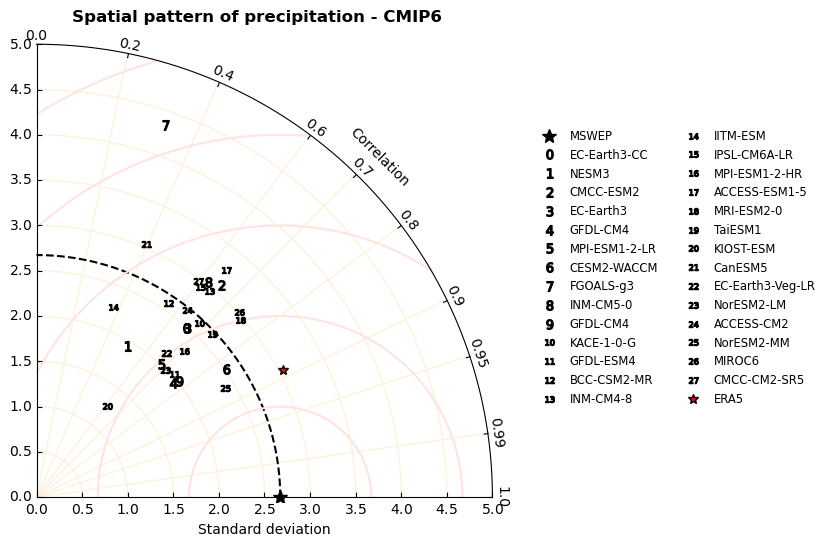

In [19]:
# make Taylor diagram
fig = plt.figure(figsize = (6,6), dpi= 100, facecolor='w', edgecolor='k')
td = TaylorDiagram(ref_sd, fig = fig, label = "MSWEP", srange = (0, max_sd), extend = False)

td.add_contours(colors = "mistyrose") # lines of equal RMSE
td.add_grid(color = "papayawhip")  # lines of equal correlation & SD

for i in range(len(corrs)):
    td.add_sample(sds[i], corrs[i], marker = "$"+str(i)+"$", ms = 7, ls = '', mec = "black", label = cmip6.run.values[i])
    
td.add_sample(era5_sd, era5_corr, marker = "*", ms = 7, ls = '', mfc = "red", mec = "black", label = "ERA5")

plt.suptitle("Spatial pattern of precipitation - CMIP6", fontweight = "bold", y = 0.93)

fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center left', bbox_to_anchor = (0.95,0.5), ncols = 1, edgecolor = "w", ncol = 2)

plt.savefig("fig/taylor-diagram_pr_spatial_cmip6.png")

## **Spatial pattern - tmin/tmax**

In [31]:
varnm = "tasmax"

# load reference dataset
mswx_varnm = re.sub("as","",varnm)
mswx = xr.open_dataset("cordex_spatial/mswx_"+mswx_varnm+"_spatial.nc").air_temperature.rename(varnm)

# load other obs. datasets for comparison
era5 = xr.open_dataset("cordex_spatial/era5_"+varnm+"_regidded.nc")[varnm]
era5_corr = xr.corr(era5, mswx)
era5_sd = era5.std()

In [32]:
# load models for comparison
fpath = "/rds/general/project/wwa/ephemeral/amazon_drought/cmip/spatial/"
cmip6 = xr.open_dataset(varnm+"_cmip6-regridded-to-mswep.nc")[varnm]

corrs, sds, ref_sd = taylor_scores(cmip6, mswx)
max_sd = max(np.ceil(max(sds)) / ref_sd, 1.1)
min_corr = min(corrs)

In [33]:
# create dataframe of scores for easier model evaluation
td_df = pd.DataFrame({"mdl" : [re.sub("i1p1","",r) for r in cmip6.run.values], "cor" : corrs, "sd" : sds}).set_index("mdl")

# td_df.loc[td_df.cor >= 0.8, "eval"] = "good"
# td_df.loc[td_df.cor >= 0.7, "eval"] = "reasonable"
# td_df.loc[(td_df.cor < 0.7) | (td_df.sd < 1.6), "eval"] = "bad"

td_df.sort_index().to_csv("taylor-diagram_"+varnm+"_cmip6_spatial-scores.csv")

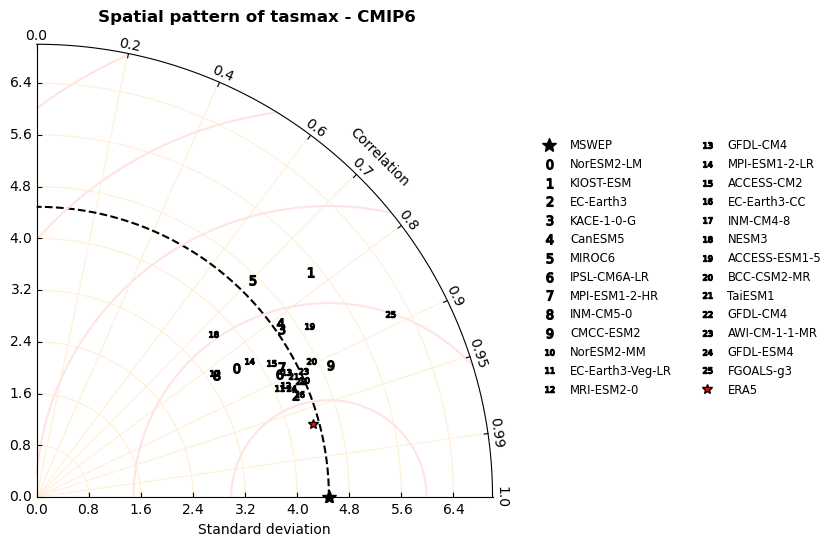

In [34]:
# make Taylor diagram
fig = plt.figure(figsize = (6,6), dpi= 100, facecolor='w', edgecolor='k')
td = TaylorDiagram(ref_sd, fig = fig, label = "MSWEP", srange = (0, max_sd), extend = False)

td.add_contours(colors = "mistyrose") # lines of equal RMSE
td.add_grid(color = "papayawhip")  # lines of equal correlation & SD

for i in range(len(corrs)):
    td.add_sample(sds[i], corrs[i], marker = "$"+str(i)+"$", ms = 7, ls = '', mec = "black", label = cmip6.run.values[i])
    
td.add_sample(era5_sd, era5_corr, marker = "*", ms = 7, ls = '', mfc = "red", mec = "black", label = "ERA5")

plt.suptitle("Spatial pattern of "+varnm+" - CMIP6", fontweight = "bold", y = 0.93)

fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center left', bbox_to_anchor = (0.95,0.5), ncols = 1, edgecolor = "w", ncol = 2)

plt.savefig("fig/taylor-diagram_"+varnm+"_spatial_cmip6.png")

---
---
# **Synthesis plots**

In [29]:
varnm = "spi"

df = {t+"_"+time : pd.read_fwf("synthesis/synth_"+varnm+"_"+t+"_"+time+".txt", comment = "#", header = None, widths = [5,5,12,12,12,12,12,4,99], 
                 names = ["y0", "y1", "est", "lower", "upper", "l_wb", "u_wb", "group", "model"], index_col = "model") for time in ["past", "proj"] for t in ["pr", "di"]}

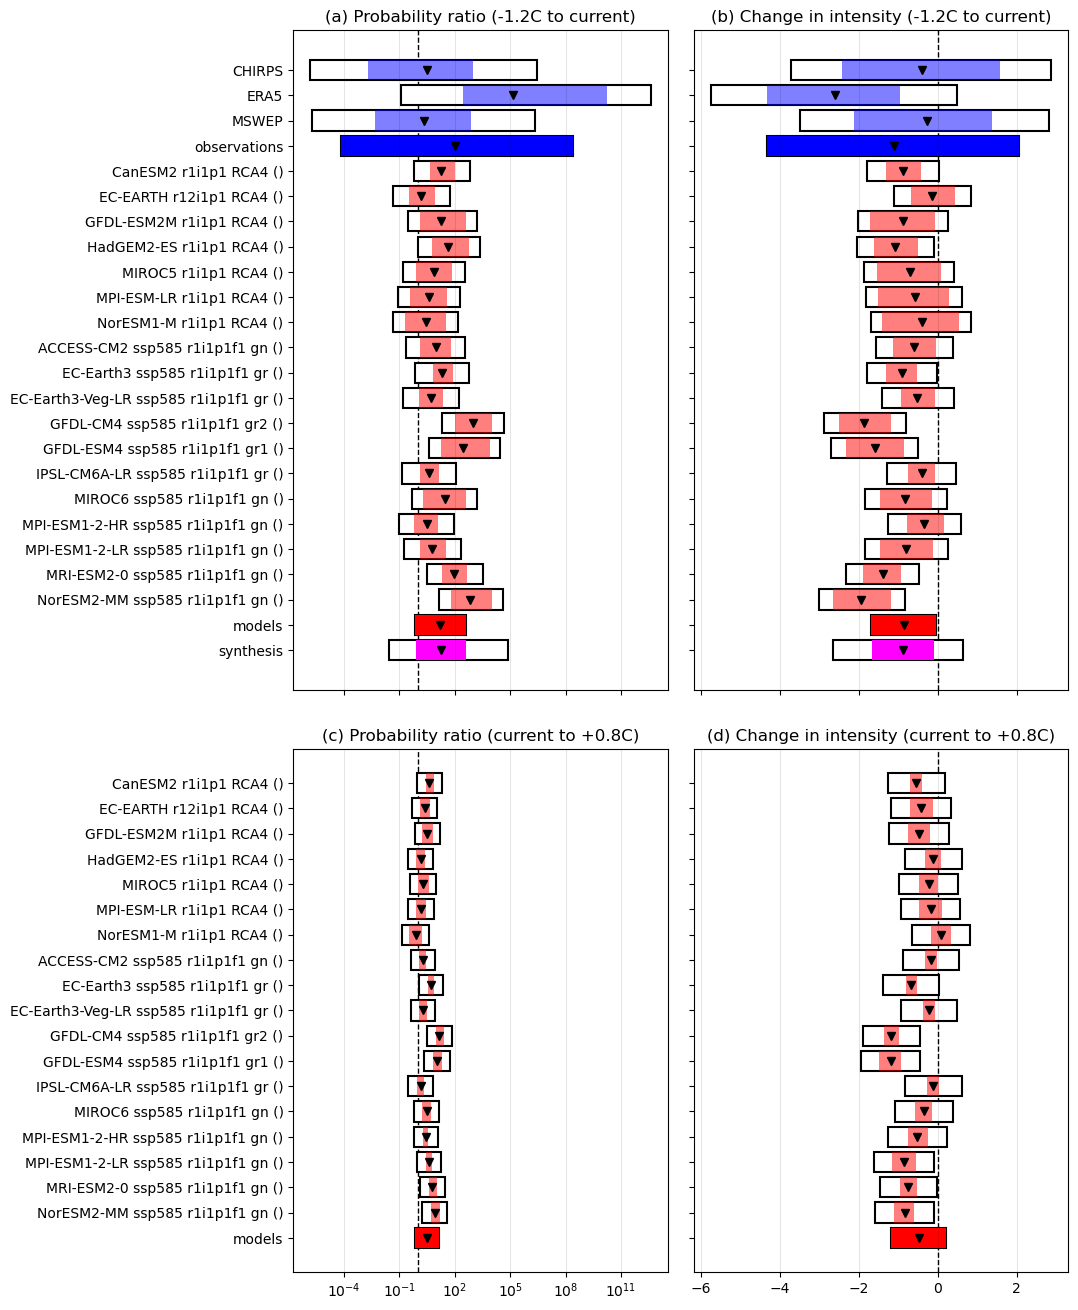

In [30]:
################################################################################################################################################

fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (10,(len(df["di_past"]) + len(df["di_proj"])) * 3/8), dpi = 100,
                        sharey = "row", sharex = "col", gridspec_kw = {"height_ratios" : [len(df["pr_past"]), len(df["pr_proj"])]})
plt.subplots_adjust(wspace = 0.07, hspace = 0.1)

pr_ax = axs[:,0]; di_ax = axs[:,1]

gcols = ["blue", "blue", "red", "red", "magenta"]
galpha = [0.5,1,0.5,1,1]

for ax in pr_ax: ax.axvline(1, ls = "--", color = "k", lw = 1, zorder = -99)
for ax in di_ax: ax.axvline(0, ls = "--", color = "k", lw = 1, zorder = -99)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

for i in range(2):
    for j in range(2):
        
        ax = axs[i,j]
        ds = ["pr", "di"][j]+"_"+["past", "proj"][i]
        res = df[ds]
        ttl = "("+["a","b","c","d"][i*2+j]+ ") "+["Probability ratio", "Change in intensity"][j]+" "+["(-1.2C to current)", "(current to +0.8C)"][i]
        
        ax.set_title(ttl)
        
        ax.grid(axis = "x", color = "k", alpha = 0.1, ls = "-", zorder = -99)
        
        for k in range(len(res)):
            
            r = res.iloc[k]
            ax.add_patch(Rectangle((r.l_wb,-k-0.4), r.u_wb - r.l_wb, 0.8, edgecolor = "k", facecolor = "w", lw = 1.5))
            ax.add_patch(Rectangle((r.lower,-k-0.4), r.upper - r.lower, 0.8, facecolor = gcols[int(r.group)-1], alpha = galpha[int(r.group)-1]))

            ax.plot(r.est, -k, color = "k", marker = "v")  
            
axs[0,0].set_xscale('log') 
# axs[1,0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

axs[0,0].set_yticks(range(0, -len(df["pr_past"]), -1))
axs[0,0].set_yticklabels([re.sub('"', '', r).strip() for r in df["pr_past"].index])

axs[1,0].set_yticks(range(0, -len(df["pr_proj"]), -1))
axs[1,0].set_yticklabels([re.sub('"', '', r).strip() for r in df["pr_proj"].index])

plt.savefig("fig/synthesis_"+varnm+".png")